# Color Identification in Images Lab

## Importing the required libraries

In [1]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from PIL import Image
import requests
from io import BytesIO

## Function to load colors from a CSV file

In [2]:
def load_colors(csv_path):
    columns = ['ColorName', 'Hex', 'R', 'G', 'B']
    colors = pd.read_csv(csv_path, names=columns)
    return colors

## Function to get the closest color name using LAB color space

In [3]:
def get_color_name(R, G, B, colors_df):
    # Convert RGB to LAB (CIELAB) color space for better perceptual matching
    color_diff = []
    for index, row in colors_df.iterrows():
        lab1 = cv2.cvtColor(np.uint8([[row[['B', 'G', 'R']]]]), cv2.COLOR_BGR2LAB)
        lab2 = cv2.cvtColor(np.uint8([[[B, G, R]]]), cv2.COLOR_BGR2LAB)
        delta_e = np.linalg.norm(lab1 - lab2)  # Euclidean distance in LAB space
        color_diff.append((delta_e, row['ColorName']))
    
    # Get the closest color
    closest_color = min(color_diff, key=lambda x: x[0])
    return closest_color[1]

## Function to identify colors in image at specific points

In [4]:
def identify_colors_in_image(image, colors_df, num_points=5):
    height, width = image.shape[:2]
    results = []
    
    # Create a grid of points to sample colors
    x_points = np.linspace(width * 0.1, width * 0.9, num_points, dtype=int)
    y_points = np.linspace(height * 0.1, height * 0.9, num_points, dtype=int)
    
    for x in x_points:
        for y in y_points:
            b, g, r = image[y, x]
            color_name = get_color_name(r, g, b, colors_df)
            results.append({
                'position': (x, y),
                'rgb': (r, g, b),
                'color_name': color_name
            })
    
    return results

## Function to display image with color identification

In [5]:
def display_colors(image, color_results, grid_size=5):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Display original image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Display image with marked points and color information
    marked_image = image.copy()
    
    # Get unique colors for legend
    unique_colors = {}
    for result in color_results:
        if result['color_name'] not in unique_colors:
            unique_colors[result['color_name']] = result['rgb']
    
    # Draw points on image
    for result in color_results:
        x, y = result['position']
        r, g, b = result['rgb']
        cv2.circle(marked_image, (x, y), 5, (0, 0, 255), -1)  # Mark with red circles
    
    axes[1].imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Color Identification')
    axes[1].axis('off')
    
    # Create a color legend
    legend_elements = []
    for color_name, (r, g, b) in unique_colors.items():
        color_patch = plt.Rectangle((0, 0), 1, 1, fc=(r/255, g/255, b/255))
        legend_elements.append((color_patch, f'{color_name} R={r} G={g} B={b}'))
    
    patches = [item[0] for item in legend_elements]
    labels = [item[1] for item in legend_elements]
    
    # Place legend outside the plot
    axes[1].legend(patches, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    # Also display a table of the colors
    color_table = pd.DataFrame([{
        'X': result['position'][0],
        'Y': result['position'][1],
        'R': result['rgb'][0],
        'G': result['rgb'][1],
        'B': result['rgb'][2],
        'Color Name': result['color_name']
    } for result in color_results])
    
    return color_table

def analyze_dominant_colors(image, colors_df, k=5):
    # Reshape the image
    pixels = image.reshape(-1, 3)
    
    # Convert to RGB (from BGR)
    pixels = pixels[:, [2, 1, 0]]
    
    # Use K-means to find dominant colors
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to uint8
    centers = np.uint8(centers)
    
    # Get the counts of each cluster
    counts = np.bincount(labels.flatten())
    
    # Sort by most frequent
    sorted_indices = np.argsort(counts)[::-1]
    sorted_centers = centers[sorted_indices]
    frequency = counts[sorted_indices] / counts.sum()
    
    # Get color names
    results = []
    for i, center in enumerate(sorted_centers):
        r, g, b = center
        color_name = get_color_name(r, g, b, colors_df)
        results.append({
            'rank': i+1,
            'rgb': (r, g, b),
            'color_name': color_name,
            'frequency': frequency[i]
        })
    
    return results

def display_dominant_colors(image, color_results):
    # Plot the image and the color palette
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Display image
    ax0.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax0.set_title('Original Image')
    ax0.axis('off')
    
    # Display color palette
    height_ratio = 0.8 / len(color_results)
    for i, result in enumerate(color_results):
        r, g, b = result['rgb']
        ax1.add_patch(plt.Rectangle((0, i*height_ratio), 0.6, height_ratio, 
                                   facecolor=(r/255, g/255, b/255)))
        ax1.text(0.65, i*height_ratio + height_ratio/2, 
                f"{result['color_name']}\nR:{r} G:{g} B:{b}\n{result['frequency']*100:.1f}%",
                va='center')
    
    ax1.set_title('Dominant Colors')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 0.8)
    ax1.axis('off')
    
    plt.tight_layout()
    plt.show()

## Main function to run the entire process

In [6]:
def main():
    # Load colors
    colors_path = '/kaggle/input/colour-detection-using-pandas-opencv/colors.csv'
    colors_df = load_colors(colors_path)
    print(f"Loaded {len(colors_df)} colors from CSV")
    
    # List images in the input directory
    # Let's check what is in the input directory since the path seems incorrect
    input_directories = ['/kaggle/input']
    
    # Try to find potential image files
    image_file_paths = []
    for base_dir in input_directories:
        for root, dirs, files in os.walk(base_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    image_file_paths.append(os.path.join(root, file))
                    if len(image_file_paths) >= 10:  # Limit to 10 images to avoid overwhelming output
                        break
    
    print(f"Found {len(image_file_paths)} potential image files")
    
    # If no images found, let's try to get an example image
    if not image_file_paths:
        print("No images found in input directories. Using a sample image...")
        # URL for a sample image (colorful geometric shapes)
        sample_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/SMPTE_Color_Bars.svg/1200px-SMPTE_Color_Bars.svg.png"
        response = requests.get(sample_image_url)
        sample_image = np.array(Image.open(BytesIO(response.content)))
        # Convert to BGR (OpenCV format)
        if len(sample_image.shape) == 3 and sample_image.shape[2] == 4:  # RGBA
            sample_image = sample_image[:, :, :3]
        sample_image = sample_image[:, :, ::-1].copy()  # RGB to BGR
        
        image = sample_image
        print("Using sample image from the web")
    else:
        # Use the first image found
        image_path = image_file_paths[0]
        print(f"Using image: {image_path}")
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image from {image_path}")
            return
    
    print(f"Image shape: {image.shape}")
    
    # Identify colors at grid points
    color_results = identify_colors_in_image(image, colors_df, num_points=5)
    
    # Display image with color identification
    color_table = display_colors(image, color_results)
    print("\nIdentified Colors at Grid Points:")
    print(color_table)
    
    # Analyze and display dominant colors
    dominant_colors = analyze_dominant_colors(image, colors_df, k=5)
    print("\nDominant Colors in the Image:")
    for result in dominant_colors:
        r, g, b = result['rgb']
        print(f"Rank {result['rank']}: {result['color_name']} (R:{r}, G:{g}, B:{b}) - {result['frequency']*100:.1f}%")
    
    display_dominant_colors(image, dominant_colors)

## Run the main function

Loaded 865 colors from CSV
Found 1 potential image files
Using image: /kaggle/input/test-image-for-color-identification-model/Image.jpg
Image shape: (675, 1200, 3)


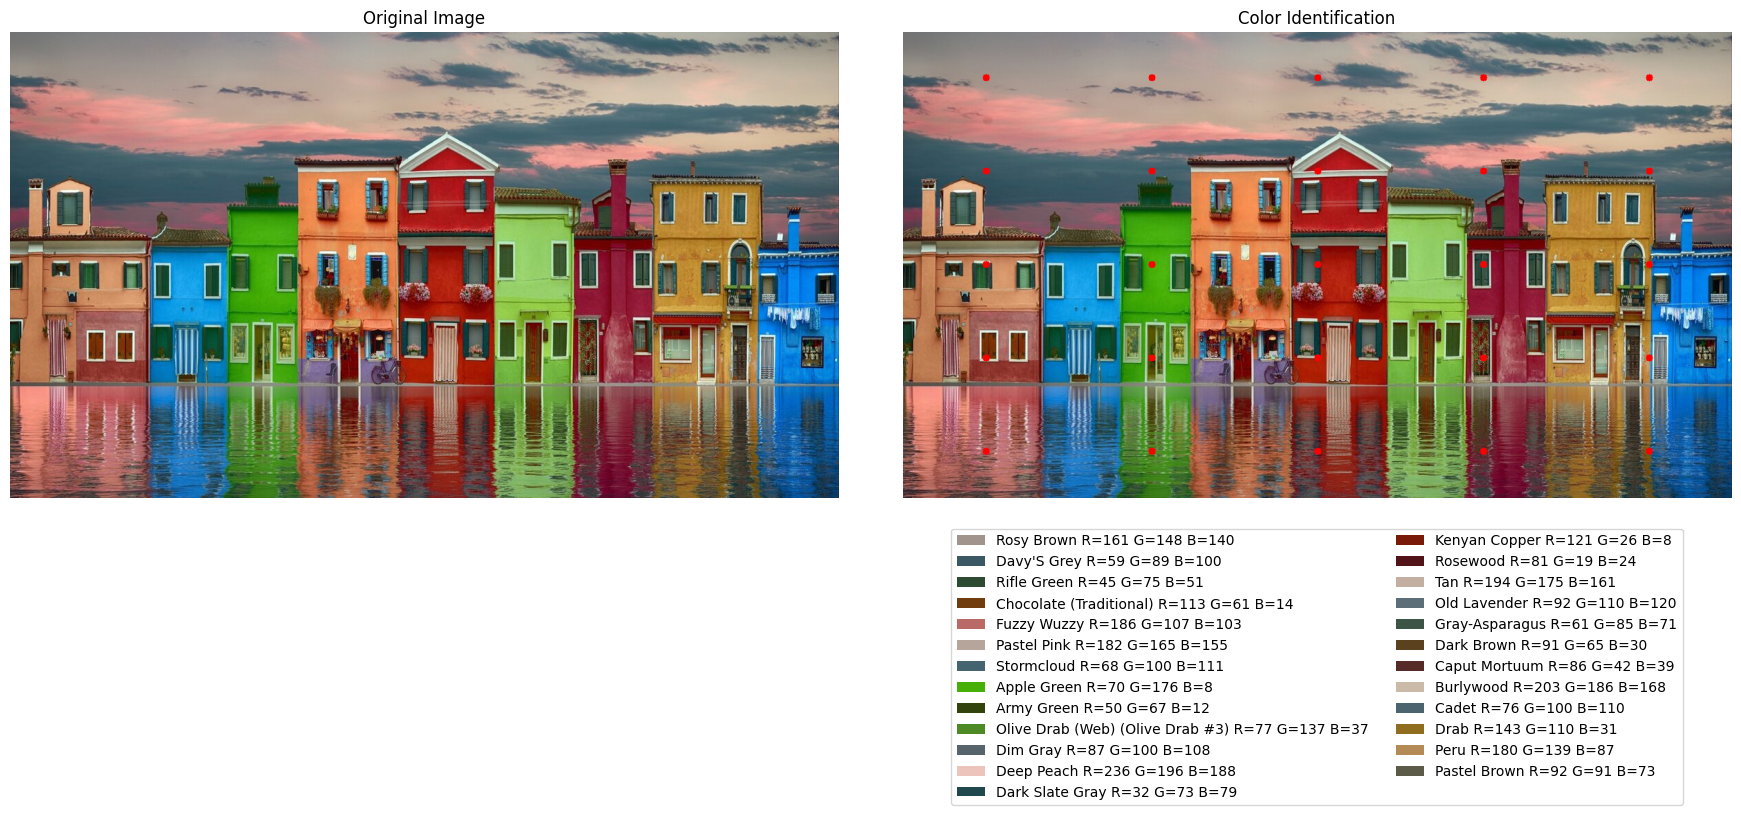


Identified Colors at Grid Points:
       X    Y    R    G    B                        Color Name
0    120   67  161  148  140                        Rosy Brown
1    120  202   59   89  100                       Davy'S Grey
2    120  337   45   75   51                       Rifle Green
3    120  472  113   61   14           Chocolate (Traditional)
4    120  607  186  107  103                       Fuzzy Wuzzy
5    360   67  182  165  155                       Pastel Pink
6    360  202   68  100  111                        Stormcloud
7    360  337   70  176    8                       Apple Green
8    360  472   50   67   12                        Army Green
9    360  607   77  137   37  Olive Drab (Web) (Olive Drab #3)
10   600   67   87  100  108                          Dim Gray
11   600  202  236  196  188                        Deep Peach
12   600  337   32   73   79                   Dark Slate Gray
13   600  472  121   26    8                     Kenyan Copper
14   600  607   81  

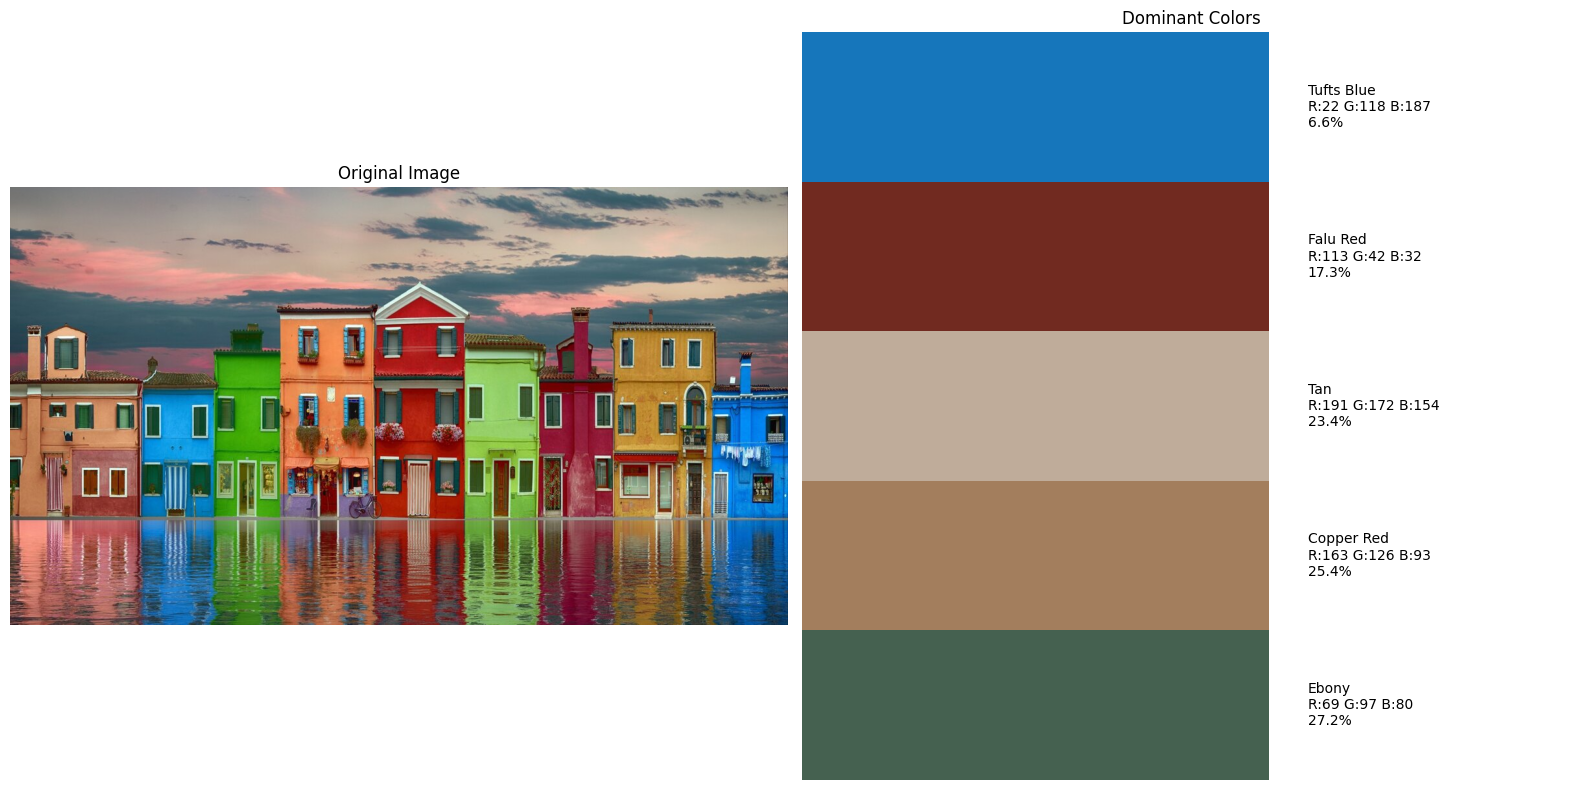

In [7]:
if __name__ == "__main__":
    main()